In [1]:
# %% A) Pobierz dane (5y) i zapisz do CSV
# pip install yfinance pandas numpy matplotlib scikit-learn

import os
import pandas as pd
import yfinance as yf

# --- USTAWIENIA ---
TICKERS = ["ADM", "BG", "ZS=F"]
OUT_DIR = "data"
OUT_CSV = os.path.join(OUT_DIR, "adm_bg_soy_close_5y.csv")

os.makedirs(OUT_DIR, exist_ok=True)

# --- POBIERANIE ---
raw = yf.download(TICKERS, period="5y", auto_adjust=True, progress=False)

# yfinance dla wielu tickerów zwraca MultiIndex kolumn (OHLC)
if isinstance(raw.columns, pd.MultiIndex):
    close = raw["Close"].copy()
else:
    # asekuracyjnie, gdyby zwrócił pojedyncze kolumny
    if "Close" not in raw.columns:
        raise ValueError("Brak kolumny 'Close' w danych z Yahoo.")
    close = raw[["Close"]].copy()
    # Jeśli pojedynczy ticker, nadaj nazwę
    close.columns = [TICKERS[0]]

# Normalizacja nazw: soja jako 'SOY'
close = close.rename(columns={"ZS=F": "SOY"}).dropna(how="all")

# Weryfikacja, czy mamy komplet kolumn
needed = {"ADM", "BG", "SOY"}
missing = needed - set(close.columns)
if missing:
    raise ValueError(f"Brakuje kolumn: {missing}. Sprawdź tickery/połączenie z Yahoo.")

# --- ZAPIS ---
close = close[["ADM", "BG", "SOY"]].dropna()
close.to_csv(OUT_CSV, index_label="date")
print(f"Zapisano {len(close)} wierszy do: {OUT_CSV}")
display(close.tail())


Zapisano 1256 wierszy do: data\adm_bg_soy_close_5y.csv


Ticker,ADM,BG,SOY
Date,,,
2025-08-11,58.279999,82.220001,989.50
2025-08-12,58.560001,82.519997,1011.75
2025-08-13,59.820000,83.239998,1023.50
2025-08-14,59.320000,82.099998,1008.50
2025-08-15,59.750000,81.779999,1042.50


Korelacja ADM vs SOY: 0.719
Korelacja BG  vs SOY: 0.339

Największe odchylenia ADM (top 5% |reszt|):
date
2022-11-22    22.912072
2022-10-31    22.861220
2022-11-25    22.386698
2022-11-01    22.145879
2022-11-23    21.824799
2022-10-28    21.747875
2021-01-12   -21.469879
2022-11-03    21.378752
2022-10-27    21.291843
2022-11-21    21.174239
Name: resid, dtype: float64

Największe odchylenia BG (top 5% |reszt|):
date
2020-09-23   -37.858689
2020-09-24   -37.512641
2020-09-30   -37.163277
2020-09-21   -37.112387
2020-10-01   -37.057621
2020-09-29   -36.874691
2020-09-22   -36.824979
2020-09-11   -36.775591
2020-09-14   -36.575010
2020-09-10   -36.494010
Name: resid, dtype: float64


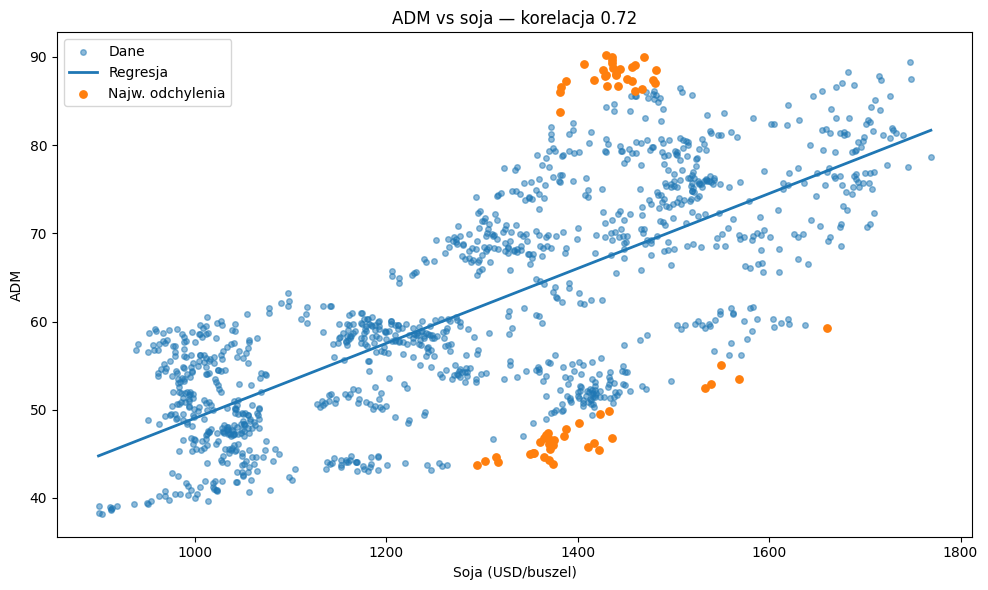

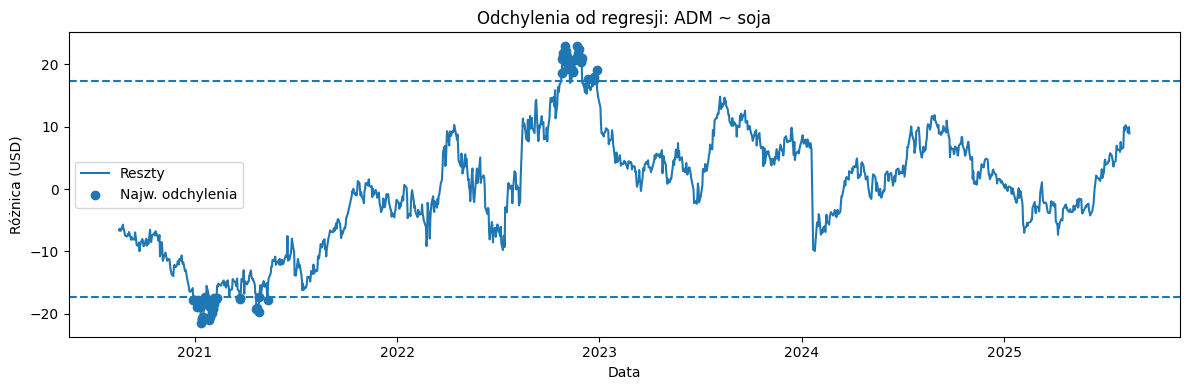

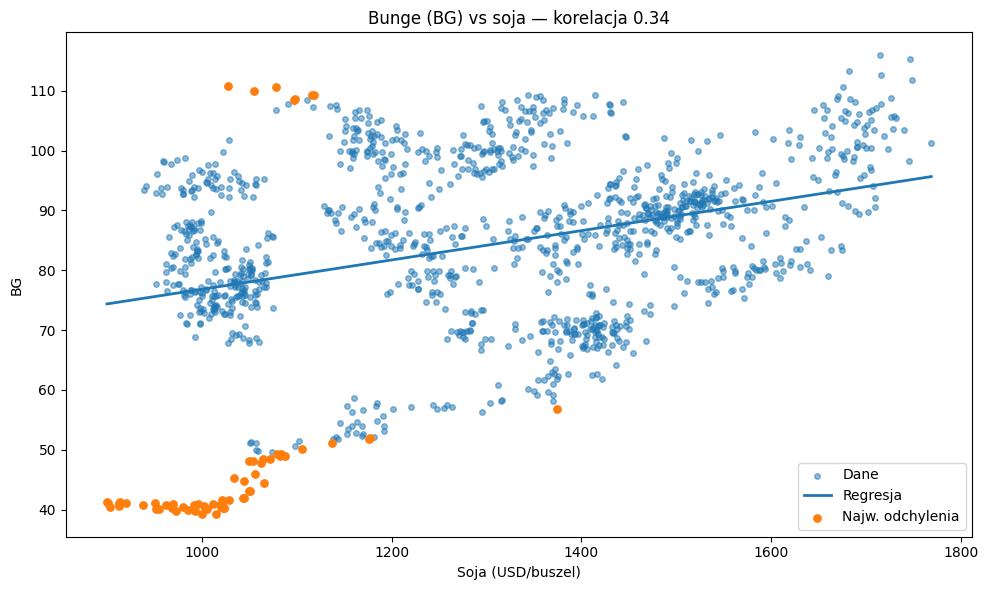

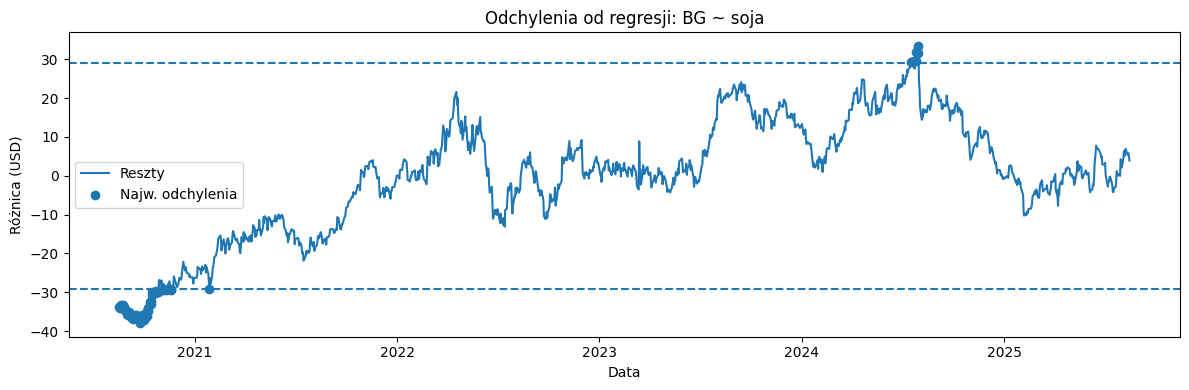

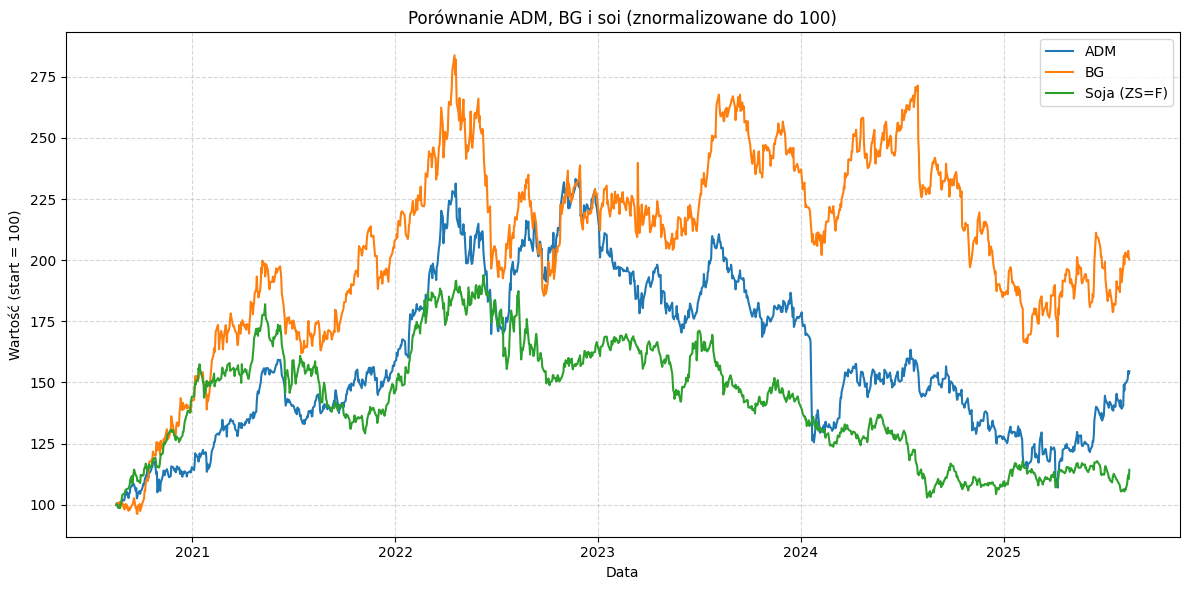

In [2]:
# %% B) Czytaj CSV → regresje, reszty, wykresy (tylko na bazie pliku)
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ── ŚCIEŻKA DO CSV zapisanym w części A ────────────────────────────────────────
IN_CSV = "data/adm_bg_soy_close_5y.csv"

# =========================
# 1) Wczytanie i sanity-check
# =========================
df = pd.read_csv(IN_CSV, parse_dates=["date"]).set_index("date").sort_index()
required_cols = {"ADM", "BG", "SOY"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Brak kolumn w {IN_CSV}: {missing}")

df = df[["ADM", "BG", "SOY"]].dropna(how="any")
if df.empty:
    raise ValueError("Brak danych po dropna(). Sprawdź plik CSV.")

# =========================
# 2) Funkcje pomocnicze
# =========================
def fit_regression(y: pd.Series, x: pd.Series):
    """Dopasuj model: y ~ a*x + b. Zwraca (model, pred, resid, corr)."""
    x, y = x.align(y, join="inner")
    X = x.values.reshape(-1, 1)
    Y = y.values
    model = LinearRegression().fit(X, Y)
    pred = model.predict(X)
    resid = Y - pred
    corr = pd.Series(y).corr(pd.Series(x))
    return model, pd.Series(pred, index=y.index, name="pred"), pd.Series(resid, index=y.index, name="resid"), corr

def big_deviation_mask(residuals: pd.Series, q: float = 0.95):
    """Maska największych odchyleń i próg q-tego percentyla |reszt|."""
    abs_res = np.abs(residuals.dropna())
    if len(abs_res) == 0:
        return pd.Series(False, index=residuals.index), np.nan
    thr = np.quantile(abs_res, q)
    mask = np.abs(residuals) >= thr
    return mask.reindex(residuals.index, fill_value=False), float(thr)

def scatter_with_regression(x: pd.Series, y: pd.Series, model: LinearRegression,
                            highlight_mask: pd.Series, title: str):
    """Scatter y vs x + linia regresji + highlight outlierów."""
    x, y = x.align(y, join="inner")
    highlight_mask = highlight_mask.reindex(y.index).fillna(False)

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5, s=16, label="Dane")
    order = np.argsort(x.values)
    x_sorted = x.values[order].reshape(-1, 1)
    y_line = model.predict(x_sorted)
    plt.plot(x_sorted, y_line, linewidth=2, label="Regresja")
    if highlight_mask.any():
        plt.scatter(x[highlight_mask], y[highlight_mask], s=28, label="Najw. odchylenia")
    plt.xlabel("Soja (USD/buszel)")
    plt.ylabel(y.name)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def residuals_in_time(residuals: pd.Series, thr: float, title: str):
    """Reszty w czasie + progi ±thr + podświetlenie outlierów."""
    residuals = residuals.sort_index()
    mask = np.abs(residuals) >= thr if np.isfinite(thr) else pd.Series(False, index=residuals.index)
    plt.figure(figsize=(12, 4))
    plt.plot(residuals.index, residuals.values, label="Reszty")
    if np.isfinite(thr):
        plt.axhline(thr, linestyle="--")
        plt.axhline(-thr, linestyle="--")
    if mask.any():
        plt.scatter(residuals[mask].index, residuals[mask].values, label="Najw. odchylenia")
    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Różnica (USD)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =========================
# 3) ADM ~ SOY oraz BG ~ SOY
# =========================
adm_model, adm_pred, adm_resid, adm_corr = fit_regression(df["ADM"], df["SOY"])
bg_model,  bg_pred,  bg_resid,  bg_corr  = fit_regression(df["BG"],  df["SOY"])

adm_mask, adm_thr = big_deviation_mask(adm_resid, 0.95)
bg_mask,  bg_thr  = big_deviation_mask(bg_resid,  0.95)

print(f"Korelacja ADM vs SOY: {adm_corr:.3f}")
print(f"Korelacja BG  vs SOY: {bg_corr:.3f}")

print("\nNajwiększe odchylenia ADM (top 5% |reszt|):")
print(adm_resid[adm_mask].sort_values(key=np.abs, ascending=False).head(10))

print("\nNajwiększe odchylenia BG (top 5% |reszt|):")
print(bg_resid[bg_mask].sort_values(key=np.abs, ascending=False).head(10))

# ── Wykresy: scatter + linia regresji + highlight ─────────────────────────────
scatter_with_regression(df["SOY"], df["ADM"], adm_model, adm_mask,
                        f"ADM vs soja — korelacja {adm_corr:.2f}")
residuals_in_time(adm_resid, adm_thr, "Odchylenia od regresji: ADM ~ soja")

scatter_with_regression(df["SOY"], df["BG"], bg_model, bg_mask,
                        f"Bunge (BG) vs soja — korelacja {bg_corr:.2f}")
residuals_in_time(bg_resid, bg_thr, "Odchylenia od regresji: BG ~ soja")

# =========================
# 4) Porównanie serii w czasie (znormalizowane do 100)
# =========================
plt.figure(figsize=(12, 6))
norm_df = df / df.iloc[0] * 100
plt.plot(norm_df.index, norm_df["ADM"], label="ADM")
plt.plot(norm_df.index, norm_df["BG"],  label="BG")
plt.plot(norm_df.index, norm_df["SOY"], label="Soja (ZS=F)")
plt.title("Porównanie ADM, BG i soi (znormalizowane do 100)")
plt.ylabel("Wartość (start = 100)")
plt.xlabel("Data")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
